In [ ]:
import pandas as pd
import numpy as np
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import IsolationForest
from sklearn.metrics import accuracy_score, recall_score, average_precision_score, f1_score
import optuna
from sklearn.model_selection import train_test_split
from itertools import product

# Z-Score

In [2]:
def zscore_detect(data: pd.DataFrame, feature_cols, threshold=3.0):
    
    out = data.copy()
    out["is_anomaly_z"] = False

    X = out[feature_cols]

    mu = X.mean(axis=0)
    sd = X.std(axis=0, ddof=0).replace(0, np.nan)

    Z = (X - mu) / sd
    out["is_anomaly_z"] = (Z.abs() > threshold).any(axis=1).fillna(False)

    return out


# OCSVM

In [3]:
def ocsvm_fit_predict(
    data: pd.DataFrame,
    feature_cols,
    nu=0.01,
    kernel="rbf",
    gamma="scale",
):

    out = data.copy()
    X = out[feature_cols].to_numpy()

    scaler = RobustScaler()
    Xs = scaler.fit_transform(X)

    model = OneClassSVM(nu=nu, kernel=kernel, gamma=gamma)
    model.fit(Xs)

    score_normal = model.decision_function(Xs).ravel()
    score_anom = -score_normal
    pred = model.predict(Xs)

    out["ocsvm_score"] = score_anom
    out["is_anomaly_ocsvm"] = (pred == -1)

    return out


# IForest

In [4]:
def iforest_fit_predict(
    data: pd.DataFrame,
    feature_cols,
    n_estimators=300,
    max_samples=0.8,
    contamination=0.01,
    max_features=1.0,
    bootstrap=False,
    random_state=42,
):

    out = data.copy()
    X = out[feature_cols].to_numpy()

    scaler = RobustScaler()
    Xs = scaler.fit_transform(X)

    model = IsolationForest(
        n_estimators=n_estimators,
        max_samples=max_samples,
        contamination=contamination,
        max_features=max_features,
        bootstrap=bootstrap,
        random_state=random_state,
        n_jobs=-1,
    )
    model.fit(Xs)

    score_normal = model.decision_function(Xs)
    score_anom = -score_normal
    pred = model.predict(Xs)

    out["if_score"] = score_anom
    out["is_anomaly_if"] = (pred == -1)

    return out


# SOM

In [5]:
def som_anomaly(
    data: pd.DataFrame,
    feature_cols,
    m=10,
    n=10,
    k=3,
    train_quantile=0.995,
    n_iter=2000,
    alpha=0.3,
    sigma=3.0,
    random_state=42,
):

    out = data.copy()
    X = out[feature_cols].to_numpy()

    scaler = RobustScaler()
    Xs = scaler.fit_transform(X)

    # ---------- SOM Training ----------
    rng = np.random.default_rng(random_state)
    N, D = Xs.shape
    W = rng.normal(0, 1, size=(m * n, D))
    coords = np.array([(i, j) for i in range(m) for j in range(n)], dtype=float)

    for t in range(n_iter):
        x = Xs[rng.integers(0, N)]
        d = np.linalg.norm(W - x, axis=1)
        bmu = np.argmin(d)

        a_t = alpha * (1 - t / max(1, n_iter))
        s_t = sigma * (1 - t / max(1, n_iter))
        s_t = max(1e-6, s_t)

        dist_grid = np.linalg.norm(coords - coords[bmu], axis=1)
        h = np.exp(-(dist_grid**2) / (2 * s_t**2))
        W += a_t * h[:, None] * (x - W)

    # ---------- Anomaly Score ----------
    d = np.linalg.norm(Xs[:, None, :] - W[None, :, :], axis=2)
    part = np.partition(d, kth=k-1, axis=1)[:, :k]
    scores = part.mean(axis=1)

    thr = np.quantile(scores, train_quantile)

    out["som_score"] = scores
    out["is_anomaly_som"] = scores > thr

    return out


# Daten laden

In [ ]:
from pathlib import Path

# Pfad zum aktuellen Notebook-Verzeichnis
current_path = Path().resolve()

# Eine Ebene nach oben gehen
parent_path = current_path.parent

# Pfad zur CSV-Datei zusammensetzen
file_path = parent_path / "data" / "SmA-Four-Tank-Batch-Process_V2.csv"

In [23]:
df = pd.read_csv(file_path, delimiter=";")
df["timestamp"] = pd.to_datetime(df["timestamp"])
# Anomalien markieren
df["Anomalie"] = (df["DeviationID ValueY"] != 1).astype(int)

# Optional: Prozessschritt filtern
df = df[df["CuStepNo ValueY"] == 8]

# Features und Label trennen
drop_cols = ["timestamp", "DeviationID ValueY"]
label_col = "Anomalie"

X_all = df.drop(columns=drop_cols + [label_col])
y_all = df[label_col]

In [ ]:
# 1. Train/Test Split
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X_all, y_all, test_size=0.1, shuffle=False, stratify=None
)

# 2. Split in Training und Validation
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.1, shuffle=False, stratify=None
)

# 3. Testdaten
X_test = X_test.values
y_test = y_test.values

# --- Nur Good-Daten für Training behalten ---
X_train = X_train[y_train == 0]
X_train = X_train.values
X_val = X_val.values

In [25]:
# --- Feature-Spalten ---
feature_cols = X_train.columns if isinstance(X_train, pd.DataFrame) else range(X_train.shape[1])

# --- Modelle & Hyperparameter-Raster ---
models = {
    "zscore": {
        "func": zscore_detect,
        "params": {"threshold": [2.5]}
        # "params": {"threshold": [2.5, 3.0, 3.5, 4.0]}
    },
    "ocsvm": {
        "func": ocsvm_fit_predict,
        "params": {
            "nu": [0.01],
            "kernel": ["rbf"],
            "gamma": ["scale"]
            # "nu": [0.01, 0.05, 0.1, 0.2],
            # "kernel": ["rbf", "linear"],
            # "gamma": ["scale", "auto"]
        }
    },
    "iforest": {
        "func": iforest_fit_predict,
        "params": {
            "n_estimators": [100],
            "max_samples": [0.5],
            "contamination": [0.01],
            "max_features": [0.5]
            # "n_estimators": [100, 300],
            # "max_samples": [0.5, 0.8],
            # "contamination": [0.01, 0.05],
            # "max_features": [0.5, 1.0]
        }
    },
    "som": {
        "func": som_anomaly,
        "params": {
            "m": [5],
            "n": [5],
            "k": [1],
            "train_quantile": [0.99]
            # "m": [5, 10],
            # "n": [5, 10],
            # "k": [1, 3],
            # "train_quantile": [0.99, 0.995]
        }
    }
}

# --- Bestes Modell suchen ---
results = []  # Liste für alle Ergebnisse

for name, info in models.items():
    func = info["func"]
    param_grid = info["params"]

    # Alle Parameterkombinationen
    keys, values = zip(*param_grid.items())
    for combination in product(*values):
        params = dict(zip(keys, combination))
        
        # Modell trainieren auf Trainingsdaten (nur Good)
        func(
            pd.DataFrame(X_train, columns=feature_cols),
            feature_cols=feature_cols,
            **params
        )
        
        # Predictions auf Validation-Set
        val_pred_df = func(
            pd.DataFrame(X_val, columns=feature_cols),
            feature_cols=feature_cols,
            **params
        )
        
        # Welche Spalte für Preds?
        if name == "zscore":
            y_val_pred = val_pred_df["is_anomaly_z"].astype(int)
        elif name == "ocsvm":
            y_val_pred = val_pred_df["is_anomaly_ocsvm"].astype(int)
        elif name == "iforest":
            y_val_pred = val_pred_df["is_anomaly_if"].astype(int)
        elif name == "som":
            y_val_pred = val_pred_df["is_anomaly_som"].astype(int)
        
        # F1-Score auf Validation
        score = f1_score(y_val, y_val_pred)
        
        # Ergebnis speichern
        results.append({
            "model": name,
            "params": params,
            "f1_score": score
        })

# --- Alle Ergebnisse sortiert nach F1 ---
results_df = pd.DataFrame(results).sort_values("f1_score", ascending=False)
best_result = results_df.iloc[0]

print(f"Bestes Modell: {best_result['model']} mit F1={best_result['f1_score']:.4f}")
print(f"Beste Parameter: {best_result['params']}")

Bestes Modell: zscore mit F1=0.4378
Beste Parameter: {'threshold': 2.5}


# Nutzung Optuna

In [26]:
# --- Feature-Spalten ---
feature_cols = X_train.columns if isinstance(X_train, pd.DataFrame) else range(X_train.shape[1])

# --- Objective-Funktion für Optuna ---
def objective(trial, model_name):
    # Je nach Modell verschiedene Hyperparameter vorschlagen
    if model_name == "zscore":
        threshold = trial.suggest_float("threshold", 2.0, 4.0)
        params = {"threshold": threshold}
        func = zscore_detect

    elif model_name == "ocsvm":
        nu = trial.suggest_float("nu", 0.01, 0.2)
        kernel = trial.suggest_categorical("kernel", ["rbf", "linear"])
        gamma = trial.suggest_categorical("gamma", ["scale", "auto"])
        params = {"nu": nu, "kernel": kernel, "gamma": gamma}
        func = ocsvm_fit_predict

    elif model_name == "iforest":
        n_estimators = trial.suggest_int("n_estimators", 100, 500, step=100)
        max_samples = trial.suggest_float("max_samples", 0.5, 1.0)
        contamination = trial.suggest_float("contamination", 0.01, 0.1)
        max_features = trial.suggest_float("max_features", 0.5, 1.0)
        params = {
            "n_estimators": n_estimators,
            "max_samples": max_samples,
            "contamination": contamination,
            "max_features": max_features
        }
        func = iforest_fit_predict

    elif model_name == "som":
        m = trial.suggest_int("m", 5, 15)
        n = trial.suggest_int("n", 5, 15)
        k = trial.suggest_int("k", 1, 5)
        train_quantile = trial.suggest_float("train_quantile", 0.9, 0.999)
        params = {"m": m, "n": n, "k": k, "train_quantile": train_quantile}
        func = som_anomaly

    else:
        raise ValueError(f"Unknown model {model_name}")

    # --- Trainiere auf Good-Daten ---
    func(pd.DataFrame(X_train, columns=feature_cols), feature_cols=feature_cols, **params)

    # --- Predictions auf Validation ---
    val_pred_df = func(pd.DataFrame(X_val, columns=feature_cols), feature_cols=feature_cols, **params)

    if model_name == "zscore":
        y_val_pred = val_pred_df["is_anomaly_z"].astype(int)
    elif model_name == "ocsvm":
        y_val_pred = val_pred_df["is_anomaly_ocsvm"].astype(int)
    elif model_name == "iforest":
        y_val_pred = val_pred_df["is_anomaly_if"].astype(int)
    elif model_name == "som":
        y_val_pred = val_pred_df["is_anomaly_som"].astype(int)

    # --- F1-Score auf Validation (maximieren) ---
    return f1_score(y_val, y_val_pred)

# --- Hyperparameter-Optimierung pro Modell ---
study_results = {}

for model_name in models.keys():
    study = optuna.create_study(direction="maximize")
    study.optimize(lambda trial: objective(trial, model_name), n_trials=20)
    study_results[model_name] = study

# --- Bestes Modell finden ---
best_model_name = None
best_f1 = -1
best_params = None

for model_name, study in study_results.items():
    if study.best_value > best_f1:
        best_f1 = study.best_value
        best_params = study.best_params
        best_model_name = model_name

print(f"Bestes Modell: {best_model_name} mit F1={best_f1:.4f}")
print(f"Beste Parameter: {best_params}")


[I 2026-02-12 18:54:26,252] A new study created in memory with name: no-name-753936d3-7b68-4607-b72e-06760dde3bb4
[I 2026-02-12 18:54:26,293] Trial 0 finished with value: 0.5548006665812075 and parameters: {'threshold': 2.0770514698244433}. Best is trial 0 with value: 0.5548006665812075.
[I 2026-02-12 18:54:26,356] Trial 1 finished with value: 0.37495475931958017 and parameters: {'threshold': 2.710893231999984}. Best is trial 0 with value: 0.5548006665812075.
[I 2026-02-12 18:54:26,511] Trial 2 finished with value: 0.34547331170746093 and parameters: {'threshold': 2.925559236310921}. Best is trial 0 with value: 0.5548006665812075.
[I 2026-02-12 18:54:26,546] Trial 3 finished with value: 0.3222429906542056 and parameters: {'threshold': 3.0575628709138716}. Best is trial 0 with value: 0.5548006665812075.
[I 2026-02-12 18:54:26,581] Trial 4 finished with value: 0.37224477958236657 and parameters: {'threshold': 2.724022764761658}. Best is trial 0 with value: 0.5548006665812075.
[I 2026-02-

Bestes Modell: zscore mit F1=0.5605
Beste Parameter: {'threshold': 2.0016858621258082}


In [27]:
# --- Bestes Modell final trainieren ---
if best_model_name == "zscore":
    # Trainiere auf Trainingsdaten
    final_model = zscore_detect(pd.DataFrame(X_train, columns=feature_cols), feature_cols=feature_cols, **best_params)
    # Für Vorhersage auf Testdaten
    def predict(X):
        df = zscore_detect(pd.DataFrame(X, columns=feature_cols), feature_cols=feature_cols, **best_params)
        return df["is_anomaly_z"].astype(int)
    def decision_function(X):
        df = zscore_detect(pd.DataFrame(X, columns=feature_cols), feature_cols=feature_cols, **best_params)
        return df["score_z"]  # sofern deine Funktion einen Score liefert

elif best_model_name == "ocsvm":
    final_model = ocsvm_fit_predict(pd.DataFrame(X_train, columns=feature_cols), feature_cols=feature_cols, **best_params)
    def predict(X):
        df = ocsvm_fit_predict(pd.DataFrame(X, columns=feature_cols), feature_cols=feature_cols, **best_params)
        return df["is_anomaly_ocsvm"].astype(int)
    def decision_function(X):
        df = ocsvm_fit_predict(pd.DataFrame(X, columns=feature_cols), feature_cols=feature_cols, **best_params)
        return df["score_ocsvm"]

elif best_model_name == "iforest":
    final_model = iforest_fit_predict(pd.DataFrame(X_train, columns=feature_cols), feature_cols=feature_cols, **best_params)
    def predict(X):
        df = iforest_fit_predict(pd.DataFrame(X, columns=feature_cols), feature_cols=feature_cols, **best_params)
        return df["is_anomaly_if"].astype(int)
    def decision_function(X):
        df = iforest_fit_predict(pd.DataFrame(X, columns=feature_cols), feature_cols=feature_cols, **best_params)
        return df["score_if"]

elif best_model_name == "som":
    final_model = som_anomaly(pd.DataFrame(X_train, columns=feature_cols), feature_cols=feature_cols, **best_params)
    def predict(X):
        df = som_anomaly(pd.DataFrame(X, columns=feature_cols), feature_cols=feature_cols, **best_params)
        return df["is_anomaly_som"].astype(int)
    def decision_function(X):
        df = som_anomaly(pd.DataFrame(X, columns=feature_cols), feature_cols=feature_cols, **best_params)
        return df["score_som"]

else:
    raise ValueError(f"Unknown model {best_model_name}")

# --- Vorhersage auf Testdaten ---
preds_test = predict(X_test)

# --- Evaluation ---
ap = average_precision_score(y_test, preds_test)
accuracy = accuracy_score(y_test, preds_test)
recall = recall_score(y_test, preds_test)
f1 = f1_score(y_test, preds_test)

print(f"\nEvaluation für {best_model_name}:")
print("Parameters:", best_params)
print("Accuracy:", accuracy)
print("Recall:", recall)
print("F1-Score:", f1)
print("Average Precision:", ap)


Evaluation für zscore:
Parameters: {'threshold': 2.0016858621258082}
Accuracy: 0.4606407808190112
Recall: 0.4066525354638839
F1-Score: 0.566753777979775
Average Precision: 0.8948781639340551


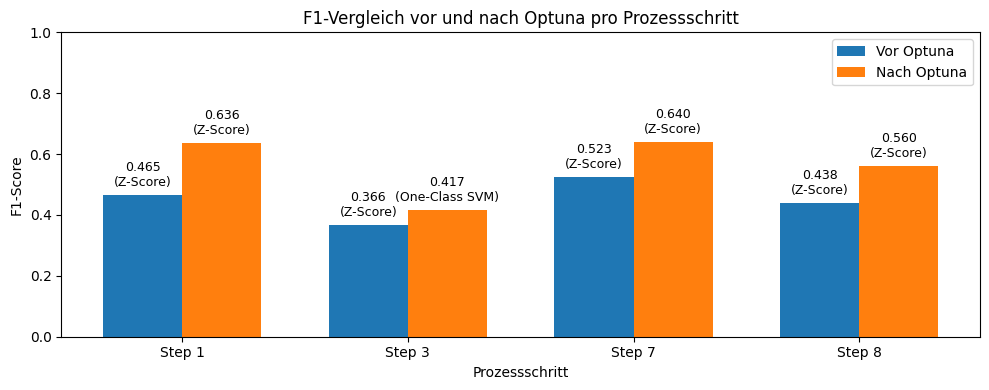

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# Prozessschritte (aufsteigend)
steps = ["Step 1", "Step 3", "Step 7", "Step 8"]

# F1-Scores VOR Optuna
f1_before = [
    0.4645,  # Step 1
    0.3659,  # Step 3
    0.5232,  # Step 7
    0.4378   # Step 8
]

models_before = [
    "Z-Score",
    "Z-Score",
    "Z-Score",
    "Z-Score"
]

# F1-Scores NACH Optuna
f1_after = [
    0.6356,  # Step 1
    0.4174,  # Step 3
    0.6402,  # Step 7
    0.5605   # Step 8
]

models_after = [
    "Z-Score",
    "One-Class SVM",
    "Z-Score",
    "Z-Score"
]

x = np.arange(len(steps))
width = 0.35

plt.figure(figsize=(10, 4))
plt.bar(x - width/2, f1_before, width, label="Vor Optuna")
plt.bar(x + width/2, f1_after, width, label="Nach Optuna")

plt.xticks(x, steps)
plt.ylim(0, 1)
plt.xlabel("Prozessschritt")
plt.ylabel("F1-Score")
plt.title("F1-Vergleich vor und nach Optuna pro Prozessschritt")
plt.legend()

# Beschriftung mit F1 + Modell
for i in range(len(steps)):
    plt.text(
        x[i] - width/2,
        f1_before[i] + 0.02,
        f"{f1_before[i]:.3f}\n({models_before[i]})",
        ha="center", va="bottom", fontsize=9
    )
    plt.text(
        x[i] + width/2,
        f1_after[i] + 0.02,
        f"{f1_after[i]:.3f}\n({models_after[i]})",
        ha="center", va="bottom", fontsize=9
    )

plt.tight_layout()
plt.show()

